In [1]:
import numpy as np
import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
import itertools
import json
import gzip
from collections import namedtuple

samples = {
    '10nM_L3'  : ['sample_1', 'sample_2', 'sample_3'],
    '100nM_L3' : ['sample_4', 'sample_5', 'sample_6'],
    '10nM_L4'  : ['sample_7', 'sample_8', 'sample_9'],
    '100nM_L4' : ['sample_10', 'sample_11', 'sample_12'],
    'apo'      : ['sample_13', 'sample_14', 'sample_15'],
    'input'    : ['sample_16', 'sample_17', 'sample_18']}

#reverse the dict so it is sample -> identifier
samples_rev = {}
for (key, lst) in samples.items():
    for i in lst:
        samples_rev[i] = key

targets = ['L3', 'L4']

In [2]:
#object to store kmer count info in a kind of clean format

class KmerEntry():
    def __init__(self, kmer, ref, mismatches, samples):
        self.kmer = kmer
        self.ref = ref
        self.counts = {sample: 0 for sample in samples}
        self.mismatches = mismatches
    
    def update_counts(self, sample, count):
        if(sample not in self.counts):
            self.counts[sample] = count
        else:
            self.counts[sample] += count
    
    def normalize_counts(self, sample, scale_factor):
        self.counts[sample] /= scale_factor
    
    def update_all_counts(self, counts):
        for key, val in counts.items():
            self.update_counts(key, val)
    
    def get_average(self, samples):
        selected_counts = []
        for sample in samples:
            selected_counts.append(
                self.counts.get(sample, 0))
        return np.mean(selected_counts), np.std(selected_counts)
    
    def get_fold_change(self, samples, reference, rescale = 1):
        (samples_mean, samples_std) = self.get_average(samples)
        (ref_mean, ref_std) = self.get_average(reference)
        
        if(ref_mean != 0):
            fc = samples_mean / ref_mean
            if(samples_mean != 0):
                fc_err = ((ref_std / ref_mean)**2 + (samples_std / samples_mean)**2)**(0.5)
            else:
                fc_err = 0
        else:
            fc = 0
            fc_err = 0
        
        return fc / rescale, fc_err / rescale
    
    
class KmerDataset:
    def __init__(self, samples):
        self.kmer_entries = {}
        self.samples = samples
    
    def update_entry(self, kmer, ref_id, mismatch_lst, sample, count):
        if(kmer not in self.kmer_entries):
            self.kmer_entries[kmer] = KmerEntry(
                kmer,
                ref_id,
                mismatch_lst,
                self.get_samples())
        self.kmer_entries[kmer].update_counts(sample, count)
        
    def normalize_total_counts(self):
        for sample in self.get_samples():
            total_counts = self.get_total_counts(sample)
            for entry in self.kmer_entries.values():
                entry.normalize_counts(sample, total_counts)
            
    def get_samples(self):
        return self.samples
    
    def get_total_counts(self, key):
        total_counts = 0
        #print(len(self.kmer_entries.values()))
        for entry in self.kmer_entries.values():
            #print(entry.counts)
            total_counts += entry.counts[key]
        
        #print(total_counts)
        return total_counts
    
    def get_wildtype_counts(self, key):
        wt_counts = {}
        for entry in self.kmer_entries.values():
            if(len(entry.mismatches) == 0):
                wt_counts[entry.ref] = entry.counts[key]
        return wt_counts

    def normalize_wildtype(self):
        for sample in self.get_samples():
            wt_counts = self.get_wildtype_counts(sample)        
            for entry in self.kmer_entries.values():
                scale_factor = wt_counts[entry.ref]
                entry.normalize_counts(sample, scale_factor)

    def get_median_fc(self, samples, reference):
        fcs = []
        for entry in self.kmer_entries.values():
            fc, _ = entry.get_fold_change(samples, reference)
            fcs.append(fc)
        return np.median(fcs)
    
    def get_kmer_fcs(self, samples, reference, norm = True):
        fc_entry = namedtuple('fc_entry', 'kmer ref mismatches fc fc_err')
        
        fc_entries = {}
        median_fc = self.get_median_fc(samples, reference)
        for entry in self.kmer_entries.values():
            if(norm):
                fc, fc_err = entry.get_fold_change(samples, reference, rescale = median_fc)
            else:
                fc, fc_err = entry.get_fold_change(samples, reference, rescale = 1)
            fc_entries[entry.kmer] = (fc_entry(
                entry.kmer,
                entry.ref,
                entry.mismatches,
                fc,
                fc_err))
        return fc_entries

In [3]:
#methods to read input data
def get_kmer_entries(kmer_entries, samples_rev, min_counts = 1):
    #data format:
    #kmer	count	ref_id	num_mismatches	mismatches
    for sample, desc in samples_rev.items():
        print('Working on %s: %s' % (sample, desc))
        fname = ('./%s/read_counts.txt.gz') % sample
        
        with gzip.open(fname, 'r') as inf:
            header = inf.readline()
            for line in inf:
                try:
                    (kmer, count, ref_id, num_mismatches, mismatch_str) = \
                        line.decode('utf-8').strip().split('\t')
                    mismatch_lst = [int(i) for i in mismatch_str.split(',')]
                except ValueError:
                    (kmer, count, ref_id, num_mismatches) = \
                        line.decode('utf-8').strip().split('\t')
                    mismatch_lst = []
                count = int(count)
                if(count >= min_counts):
                    kmer_entries.update_entry(
                        rev_comp(kmer),
                        ref_id,
                        update_coords(mismatch_lst),
                        sample,
                        count)
    return kmer_entries

def rev_comp(seq):
    seq = seq.upper()
    bases = {'A' : 'T', 'G' : 'C', 'C' : 'G', 'T' : 'A', 'N' : 'N'}
    return ''.join([bases[i] for i in reversed(seq)])

def update_coords(mismatch_lst):
    #1. reverse the sequence
    #2. offset the sequence by 3
    return [ -1*(i - 23) for i in reversed(mismatch_lst)]

def populate_kmer_struct(samples):
    kmer_entries = KmerDataset(samples_rev)
    MIN_COUNTS = 10
    
    kmer_entries = \
        get_kmer_entries(
            kmer_entries,
            samples_rev,
            min_counts = MIN_COUNTS)
    return kmer_entries
    
#read the data
kmer_entries = populate_kmer_struct(samples)

Working on sample_14: apo
Working on sample_10: 100nM_L4
Working on sample_11: 100nM_L4
Working on sample_8: 10nM_L4
Working on sample_7: 10nM_L4
Working on sample_17: input
Working on sample_5: 100nM_L3
Working on sample_3: 10nM_L3
Working on sample_15: apo
Working on sample_13: apo
Working on sample_2: 10nM_L3
Working on sample_12: 100nM_L4
Working on sample_1: 10nM_L3
Working on sample_18: input
Working on sample_16: input
Working on sample_9: 10nM_L4
Working on sample_6: 100nM_L3
Working on sample_4: 100nM_L3


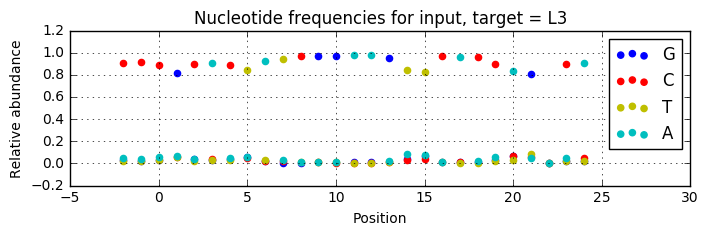

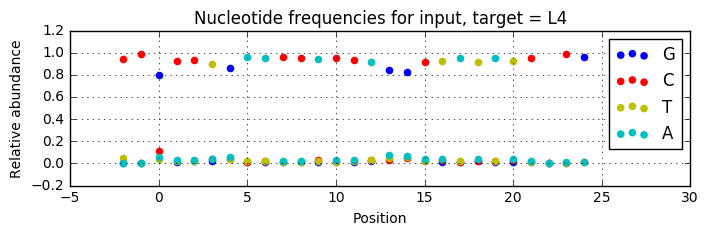

In [7]:
POS = list(range(-2, 25))

def get_nuc_freq_by_pos(key, target = 'L3'):
    reps = samples[key]
    nuc_by_pos = np.zeros((27, 4))
    nuc_to_idx = {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3}
    
    total_counts = 0
    for entry in kmer_entries.kmer_entries.values():
        if(entry.ref == target):
            average, std = entry.get_average(reps)
            total_counts += average
            for pos, nuc in zip(POS, entry.kmer):
                nuc_by_pos[pos, nuc_to_idx[nuc]] += average
    return nuc_by_pos / total_counts

def plot_nuc_freq_by_pos(expts, target = 'L3'):
    nuc_to_idx = {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3}
    nuc_by_pos = get_nuc_freq_by_pos(expts, target = target) #- get_nuc_freq_by_pos(ctrls, target = target)
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (8,2))
    x = POS
    colors = 'crby'
    y = [0]*27
    for nuc, idx in nuc_to_idx.items():
        y = nuc_by_pos[:, idx]
        ax.scatter(x, y, color = colors[idx], label = nuc)
        #ax.bar(x, y, bottom = bottom, color = colors[idx], label = nuc)
        #bottom += y
    ax.grid()
    ax.legend(loc = 0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Relative abundance')
    ax.set_title('Nucleotide frequencies for %s, target = %s' % (expts, target))
    fig.savefig('./plots/nucleotide_freqs_per_pos__sample_%s__target_%s.pdf' % (expts, target))
    
    
plot_nuc_freq_by_pos('input', target = 'L3')
plot_nuc_freq_by_pos('input', target = 'L4')

In [5]:
print('%i kmers initially' % len(list(kmer_entries.kmer_entries.items())))

thresholded_counts = {}
for i, entry in enumerate(kmer_entries.kmer_entries.values()):
    
    passed_filter = False
    for sample, reps in samples.items():
        sample_counts = []
        for rep in reps:
            sample_counts.append(entry.counts[rep])
        if all([i > 20 for i in sample_counts]):
            passed_filter = True
    if(passed_filter):
        thresholded_counts[entry.kmer] = entry

print('%i kmers after thresholding' % len(list(thresholded_counts.items())))
kmer_entries.kmer_entries = thresholded_counts
kmer_entries.normalize_total_counts()

169080 kmers initially
30428 kmers after thresholding


sample_4	sample_5	0.941598
sample_4	sample_6	0.942528
sample_5	sample_6	0.912932
sample_10	sample_11	0.883166
sample_10	sample_12	0.838403
sample_11	sample_12	0.871325
sample_1	sample_2	0.951044
sample_1	sample_3	0.943574
sample_2	sample_3	0.943601
sample_7	sample_8	0.754091
sample_7	sample_9	0.904065
sample_8	sample_9	0.787129
sample_13	sample_14	0.860333
sample_13	sample_15	0.931508
sample_14	sample_15	0.914799
sample_16	sample_17	0.955472
sample_16	sample_18	0.954793
sample_17	sample_18	0.958002


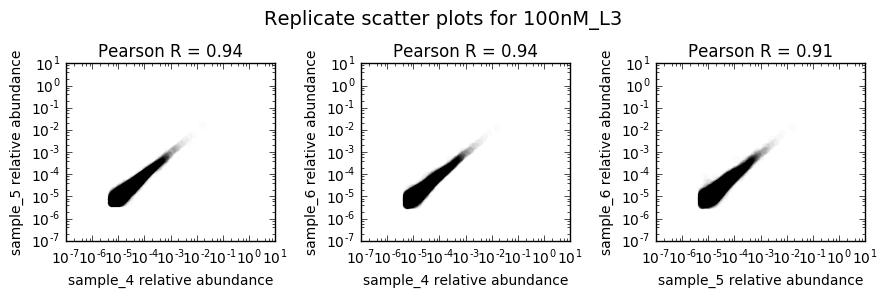

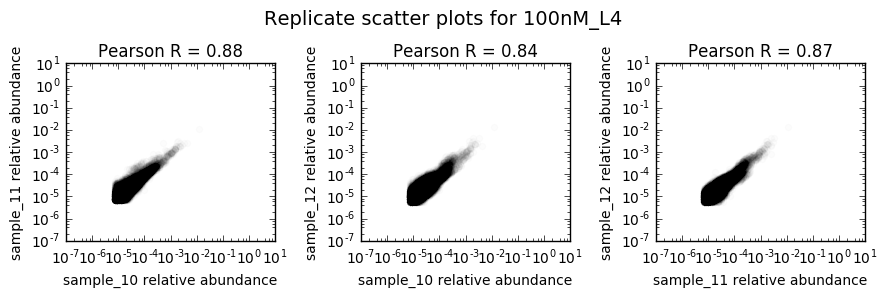

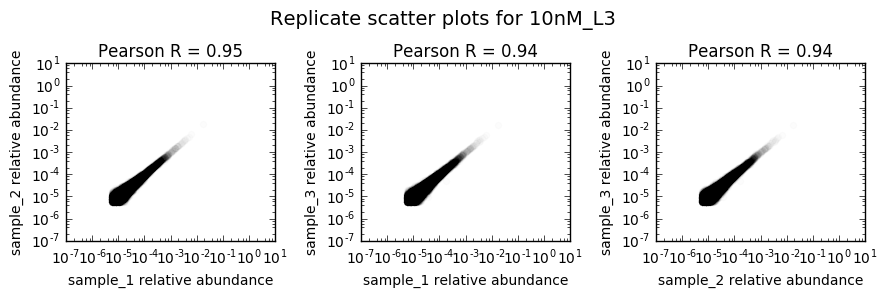

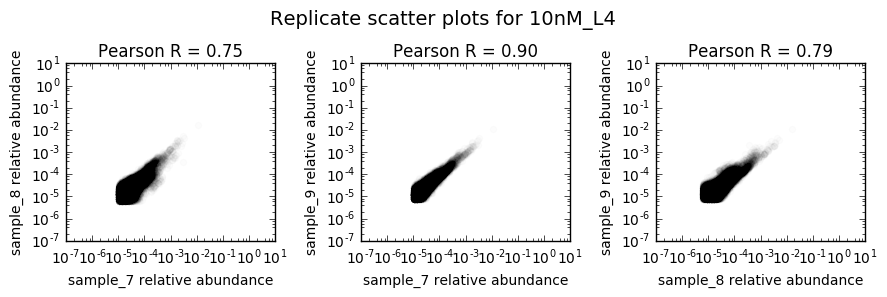

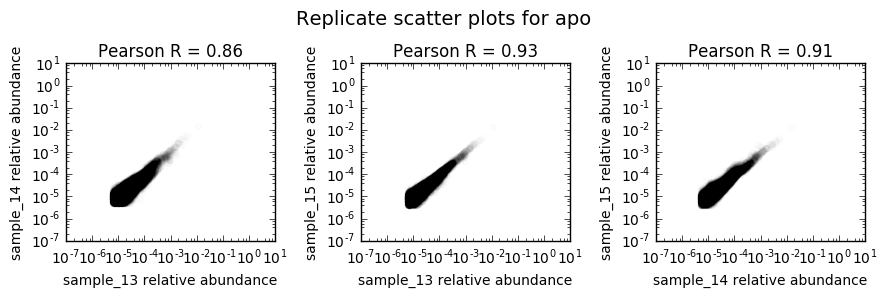

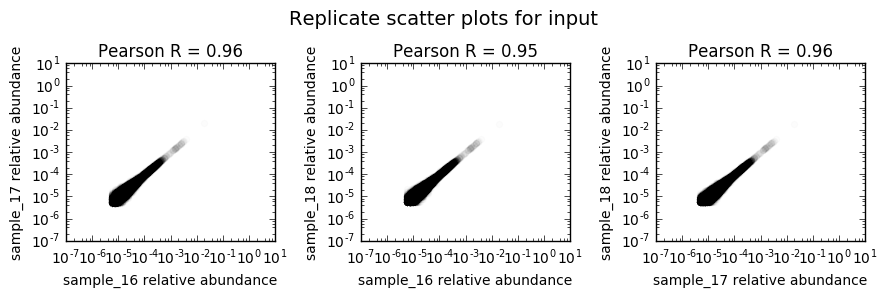

In [6]:
#compare repliacates
from scipy.stats import pearsonr
from scipy.stats import spearmanr
def plot_replicate_scatter(kmer_entries, samples, key):
    reps = samples[key]
    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(9,3))
    
    for i, (s1_key, s2_key) in enumerate(itertools.combinations(reps, 2)):
        #print('Working on samples %s, %s' % (s1_key, s2_key)),
        
        x = []
        y = []
        for kmer, entry in kmer_entries.kmer_entries.items():
            s1_counts = entry.counts.get(s1_key, 0)
            s2_counts = entry.counts.get(s2_key, 0)
            
            if s1_counts != 0 and s2_counts != 0:
                x.append(s1_counts)
                y.append(s2_counts)
        ax[i].scatter(x, y, color = 'k', alpha = 0.01)
        ax[i].set_xlabel('%s relative abundance' % s1_key)
        ax[i].set_ylabel('%s relative abundance' % s2_key)
        ax[i].set_xscale('log')
        ax[i].set_yscale('log')
        ax[i].set_xlim([10**-7, 10**1])
        ax[i].set_ylim([10**-7, 10**1])
        
        pearson, _ = pearsonr(np.log10(x), np.log10(y))
        ax[i].set_title('Pearson R = %0.02f' % (pearson))
        
        print('%s\t%s\t%f' % (s1_key, s2_key, pearson))

    fig.suptitle('Replicate scatter plots for %s' % key, size = 14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)

#Replicate scatter plots with pearson r (for every replicate pair)
for sample_key in sorted(list(samples.keys())):
    plot_replicate_scatter(kmer_entries, samples, sample_key)

In [ ]:
#plot bar chart of summed relative abundances
def plot_lib_abundance_bar(kmer_entries):
    
    x = []
    y = []
    yerr = []
    colors = []
    xlabels = []
    xpos = 1
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(6,3))

    for sample_desc in reversed(sorted(list(samples.keys()))):
        samples_lst = samples[sample_desc]
        num_samples = len(samples_lst)
        
        total_counts = {key: [0]*num_samples for key in targets}
        for i, sample in enumerate(samples_lst):
            for kmer, entry in kmer_entries.kmer_entries.items():
                total_counts[entry.ref][i] += entry.counts[sample]
        num_targets = 2
        for target, counts_lst in sorted(total_counts.items()):
            y.append(np.mean(counts_lst))
            yerr.append(np.std(counts_lst))
            x.append(xpos)
            xpos += (1.0 / (num_targets + 1))
            
            if(target == 'L3'):
                colors.append('c')
            else:
                colors.append('r')
            
        xlabels.append(sample_desc)
        xpos += (1.0 / (num_targets + 1))
        
    bars = ax.bar(x, y, 
        width = (1.0 / (num_samples + 1)), yerr = yerr, ecolor = 'k', 
        capsize=0, color = colors)
    ax.set_xticklabels(xlabels, rotation = 45)
    
    ax.set_xticks([1,2,3,4,5,6])
    ax.set_ylabel('Relative abundance')
    
    ax.set_title('Target relative abundances in datasets\nBlue: L3, Red: L4')
    ax.grid()
    plt.tight_layout()
    
#bar plot of rel abundance for each library in each sample
plot_lib_abundance_bar(kmer_entries)

In [ ]:
def plot_fcs_scatter(samples, s1, s2, ctrls, lim = [0,10]):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,6))
    s1_fc = kmer_entries.get_kmer_fcs(samples[s1], samples[ctrls], norm = True)
    s2_fc = kmer_entries.get_kmer_fcs(samples[s2], samples[ctrls], norm = True)
    
    colors = {'L3' : 'b', 'L4' : 'r'}
    
    x = []
    y = []
    c = []
    for kmer in s1_fc.keys():
        x.append(s1_fc[kmer].fc)
        y.append(s2_fc[kmer].fc)
        c.append(colors[s2_fc[kmer].ref])
    ax.scatter(x, y, color = c, alpha = 0.1)
    
    ax.set_xlabel('Fold change: %s / %s' % (s1, ctrls))
    ax.set_ylabel('Fold change: %s / %s' % (s2, ctrls))
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.grid()
    
    fig.savefig('./plots/orthogonality_plot__%s_%s__%s.pdf' % (s1, s2, ctrls))
    fig.savefig('./plots/orthogonality_plot__%s_%s__%s.png' % (s1, s2, ctrls), dpi= 600)
    

plot_fcs_scatter(samples, '100nM_L3', '100nM_L4', 'apo', lim = [0,8])
plot_fcs_scatter(samples, '10nM_L3', '10nM_L4', 'apo', lim = [0, 8])

plot_fcs_scatter(samples, '100nM_L3', '100nM_L4', 'input', lim = [0,8])
plot_fcs_scatter(samples, '10nM_L3', '10nM_L4', 'input', lim = [0, 8])

In [ ]:
"""
enrichment value for perfectly complementary sequences
"""
def get_wt_enrichment(expts, ctrls):
    targets = ['L3', 'L4']
    expts_wt_counts = {'L3':[], 'L4':[]}
    ctrls_wt_counts = {'L3':[], 'L4':[]}

    for rep in samples[expts]:
        rep_wt_counts = (kmer_entries.get_wildtype_counts(rep))
        for key, val in rep_wt_counts.items():
            expts_wt_counts[key].append(val)
    for rep in samples[ctrls]:
        rep_wt_counts = (kmer_entries.get_wildtype_counts(rep))
        for key, val in rep_wt_counts.items():
            ctrls_wt_counts[key].append(val)
    
    #print(expts_wt_counts)
    #print(ctrls_wt_counts)
    
    fcs = {}
    fcs_err = {}
    for key in expts_wt_counts.keys():
        fcs[key] = np.mean(expts_wt_counts[key]) / np.mean(ctrls_wt_counts[key])
        fcs_err[key] = \
            ((np.std(expts_wt_counts[key]) / np.mean(expts_wt_counts[key]))**2 + \
             (np.std(ctrls_wt_counts[key]) / np.mean(ctrls_wt_counts[key]))**2)**0.5
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4))
    
    #print(fcs)
    labels = []
    for i, key in enumerate(fcs.keys()):
        if(key == 'L3'):
            color = 'c'
        else:
            color = 'r'
        ax.bar(i, fcs[key], yerr = fcs_err[key], color = color, ecolor = 'k', capsize = 0)
        labels.append(key + ' target')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(labels, rotation = 45)
    ax.set_ylabel('Fold change')
    ax.set_title('Fold change for wildtype seqs: %s vs %s' % (expts, ctrls))
    plt.tight_layout()
    fig.savefig('./plots/Wildtype_seq_FC__%s_vs_%s.pdf' % (expts, ctrls))

    
get_wt_enrichment('100nM_L3', 'apo')
get_wt_enrichment('100nM_L4', 'apo')
get_wt_enrichment('10nM_L3', 'apo')
get_wt_enrichment('10nM_L4', 'apo')

/usr/local/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


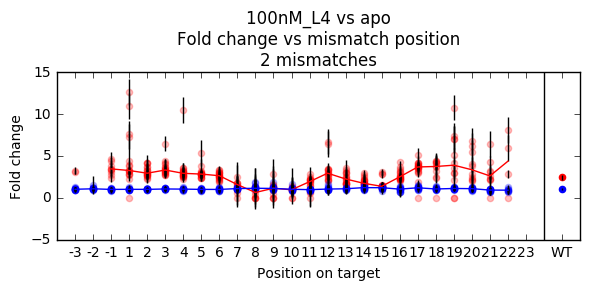

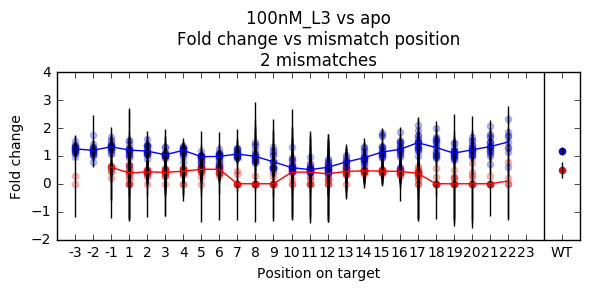

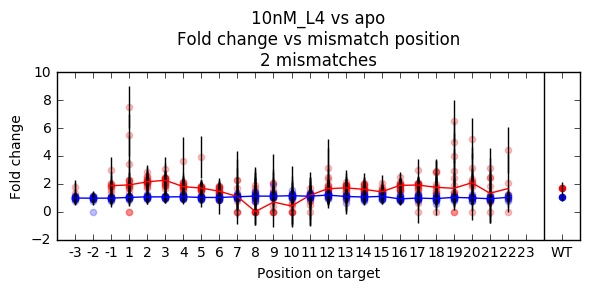

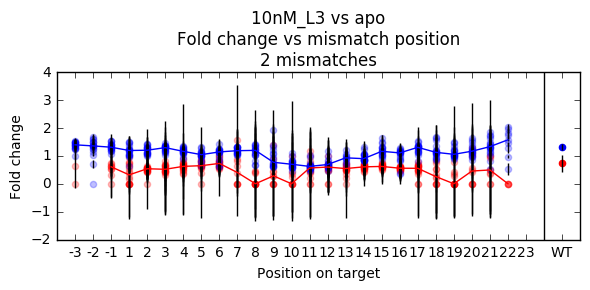

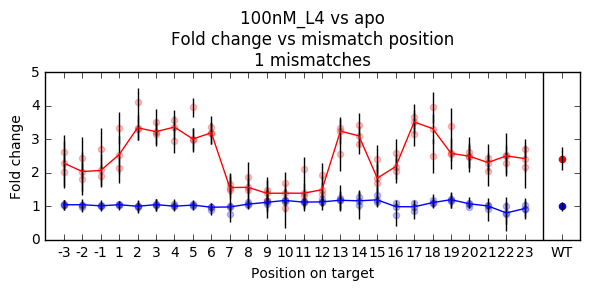

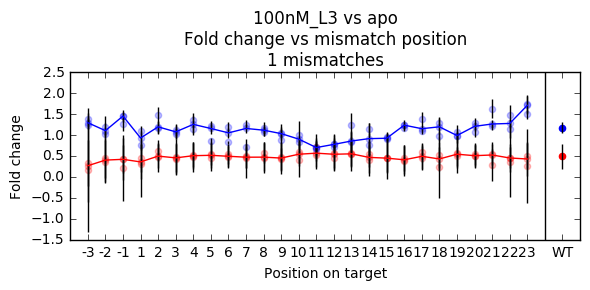

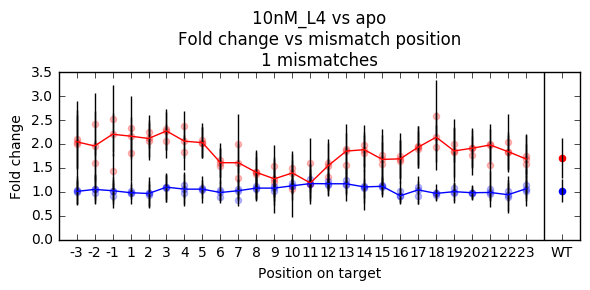

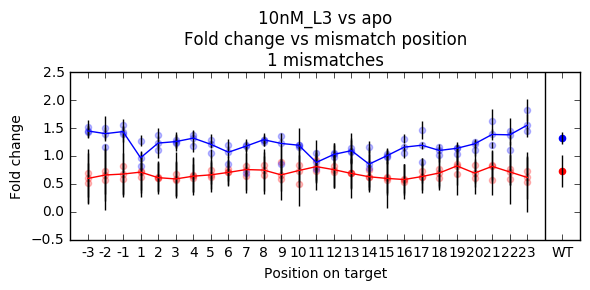

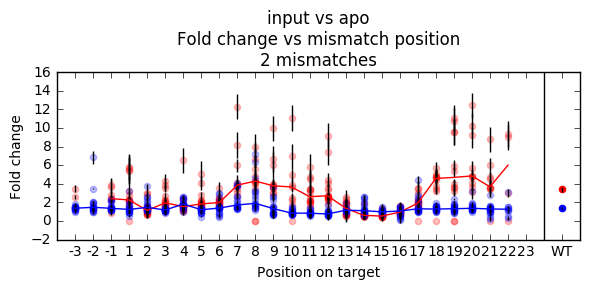

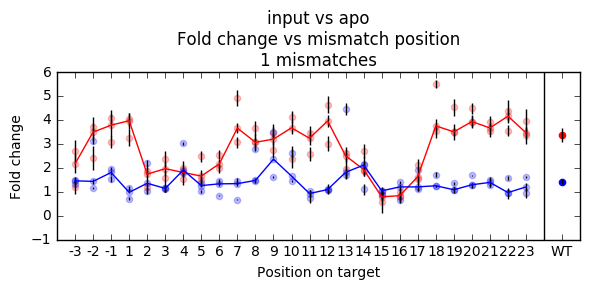

In [26]:
"""
mismatch vs position plots
"""

def plot_fc_vs_mismatch_medians(samples, expts, ctrls, num_mismatches = 1, window = 1):
    fc = kmer_entries.get_kmer_fcs(samples[expts], samples[ctrls], norm = True)
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,3))    
    targets = {'L3' : 'b', 'L4' : 'r'}
    
    kmer_len = 27
    wt_x = 25

    for target in targets.keys():
        plot_data = []
        for i in range(kmer_len):
            plot_data.append([])
            
        for fc_entry in fc.values():    
            if fc_entry.ref == target and \
                len(fc_entry.mismatches) == num_mismatches and \
                fc_entry.mismatches[-1] - fc_entry.mismatches[0] <= window:
                
                m = fc_entry.mismatches[0]
                y = fc_entry.fc
                y_err = fc_entry.fc_err
                ax.errorbar(m, y, yerr = y_err, ecolor = 'k', color = 'None', capsize = 0)
                ax.scatter(m, y, color = targets[target], alpha = 0.25)
                plot_data[m].append(y)
            #plot wt sequence
            if fc_entry.ref == target and len(fc_entry.mismatches) == 0:
                wt_y = fc_entry.fc
                wt_y_err = fc_entry.fc_err
                ax.scatter(wt_x, wt_y, color = targets[target], alpha = 1)
                ax.errorbar(wt_x, wt_y, wt_y_err, ecolor = 'k', color = 'None', capsize = 0)
                
        medians = []
        x = list(range(-2, 25))
        for i in x:
            medians.append(np.median(plot_data[i]))
        ax.plot(x, medians, color = targets[target], label = '%s median' % target)
        
    ax.axvline(wt_x - 1, color = 'k')
    ax.set_xlabel('Position on target')
    ax.set_ylabel('Fold change')
    #ax.grid()
    
    ax.set_xticks(list(range(-2, 24)) + [25])
    xticklabels = '-3,-2,-1'.split(',') + [str(i) for i in list(range(1, 24))] + ['WT']
    ax.set_xticklabels(xticklabels)
    
    ax.set_title(
        '%s vs %s\nFold change vs mismatch position\n%i mismatches' % \
        (expts, ctrls, num_mismatches))
    ax.set_xlim([-3, 26])
    #ax.legend()
    plt.tight_layout()
    fig.savefig('./plots/Mismatch_pos_vs_FC__%s_vs_%s__%i_mismatches_%i_window.pdf' % \
                    (expts, ctrls, num_mismatches, window))

plot_fc_vs_mismatch_medians(samples, '100nM_L4', 'apo', num_mismatches = 2, window = 2)
plot_fc_vs_mismatch_medians(samples, '100nM_L3', 'apo', num_mismatches = 2, window = 2)
plot_fc_vs_mismatch_medians(samples, '10nM_L4', 'apo', num_mismatches = 2, window = 2)
plot_fc_vs_mismatch_medians(samples, '10nM_L3', 'apo', num_mismatches = 2, window = 2)

plot_fc_vs_mismatch_medians(samples, '100nM_L4', 'apo', num_mismatches = 1, window = 1)
plot_fc_vs_mismatch_medians(samples, '100nM_L3', 'apo', num_mismatches = 1, window = 1)
plot_fc_vs_mismatch_medians(samples, '10nM_L4', 'apo', num_mismatches = 1, window = 1)
plot_fc_vs_mismatch_medians(samples, '10nM_L3', 'apo', num_mismatches = 1, window = 1)

plot_fc_vs_mismatch_medians(samples, 'input', 'apo', num_mismatches = 2, window = 2)
plot_fc_vs_mismatch_medians(samples, 'input', 'apo', num_mismatches = 1, window = 1)

In [ ]:
"""
bar plot number of mismatches (x), number of reads (y)
"""
TLEN = 26
def mismatches_vs_reads(target):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (4,4))
    for sample, reps in samples.items():
        if(sample == 'input'):

            y = [0]*TLEN
            for entry in kmer_entries.kmer_entries.values():
                if(target == entry.ref):
                    counts, err = entry.get_average(reps)
                    x = len(entry.mismatches)
                    y[x] += counts

            y /= np.sum(y)
            x = range(0, TLEN)
            ax.plot(x, y, label = sample)
            ax.set_xlim([0, 7])
            #ax.set_yscale('log')
        
    ax.set_xlabel('Number of mismatches')
    ax.legend(fontsize = 6, loc = 2)
    ax.set_ylabel('Relative abundance over all sequences')
    ax.set_title('Library error abundances. Target %s' % (target))
    fig.savefig('./plots/mismatches_vs_combined_rel_abundance__%s__inputOnly.pdf' % (target))
    
mismatches_vs_reads('L3')
mismatches_vs_reads('L4')

In [ ]:
"""

weblogo type plot
--- x: position
--- y: change in frequency between enriched / depleted

"""

TLEN = 26

def freq_diff(samples, expts, ctrls, target = 'L3', NUM = 500, num_mismatches = None, plot = True):
    kmers_by_fc = []
    for kmer, entry in kmer_entries.kmer_entries.items():
        fc, fc_err = entry.get_fold_change(samples[expts], samples[ctrls])
        mismatch_only_kmer = get_mismatch_only_seq(kmer, entry.mismatches)
        if(entry.ref == target): 
            if(len(entry.mismatches) == num_mismatches) or (num_mismatches == None):
                kmers_by_fc.append((kmer, fc, fc_err))
    #sort
    kmers_by_fc = sorted(kmers_by_fc, key = lambda tup: tup[1])
    
    top_freqs = get_nuc_freq(kmers_by_fc[0:NUM])
    bottom_freqs = get_nuc_freq(kmers_by_fc[-1*NUM:])
    
    
    freqs_diff = {'A':[0]*TLEN, 'C':[0]*TLEN, 'G':[0]*TLEN, 'T':[0]*TLEN,}
    for pos, nuc in itertools.product(list(range(TLEN)), ['A', 'C', 'G', 'T']):
        freqs_diff[nuc][pos] = top_freqs[nuc][pos] - bottom_freqs[nuc][pos]
          
    if plot: 
        fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,3))
        for nuc, color in zip('ACGT', 'rbyk'):
            y = freqs_diff[nuc]
            x = range(1, 1 + len(y))
            ax.scatter(x,y, color = color, alpha = 0.5, label = nuc)
        ax.set_xlabel('Position')
        ax.set_ylabel('Change in frequency\nTop seqs vs bottom seqs')
        ax.set_title(\
            'Sample %s vs %s, target %s\n' % (expts, ctrls, target) + \
            'Position of error vs change in frequency in top %i vs bottom %i seqs' % (NUM, NUM))
        ax.legend(fontsize = 6)
        ax.grid()
        ax.set_xlim(0, TLEN + 1)
        fig.savefig('./plots/change_in_nt_freq__top_%i_vs_bottom__%s_vs_%s__target_%s.pdf' % (NUM, expts, ctrls, target))
    
    return freqs_diff
    
def get_nuc_freq(kmers):
    freqs = {'A':[0]*TLEN, 'C':[0]*TLEN, 'G':[0]*TLEN, 'T':[0]*TLEN,}
    for kmer, fc, _ in kmers:
        for i, k in enumerate(kmer):
            if k != '-':
                freqs[k][i] += 1
    return freqs

def get_mismatch_only_seq(kmer, mismatches):
    out = ''
    for i, char in enumerate(kmer):
        if(i in mismatches):
            out += char
        else:
            out += '-'
    return out


In [ ]:
_ = freq_diff(samples, '100nM_L3', 'apo', target = 'L3', NUM = 500, num_mismatches = None)
_ = freq_diff(samples, '10nM_L3', 'apo', target = 'L3', NUM = 500, num_mismatches = None)

In [ ]:
"""
permutation test
    make a (nuc x position x permutation) matrix

    for each permutation:
        shuffle kmer list randomly
        keep the top / bottom n seqs
        make a difference plot
        record value into (:,:,permutation)
    
    get p-values
        fix p- cutoff = 0.001
    for each nuc, position
        get frequency of |value| >= |actual value|

"""
import bisect

def permutation(samples, expts, ctrls, target = 'L3', NUM_REPS = 10000, NUM_KMERS = 500, CUTOFF = 0.001):
    
    obs_values = freq_diff(
        samples,
        expts,
        ctrls,
        target = target,
        NUM = NUM_KMERS,
        num_mismatches = None,
        plot = False)
    
    permutation_values = {
        'A':[[0]*NUM_REPS]*TLEN,
        'C':[[0]*NUM_REPS]*TLEN,
        'G':[[0]*NUM_REPS]*TLEN,
        'T':[[0]*NUM_REPS]*TLEN,}
    
    kmers = [(kmer, None, None) for kmer in list(kmer_entries.kmer_entries.keys())]
    for rep in range(NUM_REPS):
        np.random.shuffle(kmers)
        top_freqs = get_nuc_freq(kmers[0:NUM_KMERS])
        bottom_freqs = get_nuc_freq(kmers[-1*NUM_KMERS:])
        
        for pos, nuc in itertools.product(list(range(TLEN)), ['A', 'C', 'G', 'T']):
            permutation_values[nuc][pos][rep] = np.fabs(top_freqs[nuc][pos] - bottom_freqs[nuc][pos])
            
    #for each nuc / pos, sort the rep array
    permutation_values_sorted = permutation_values
    for pos, nuc in itertools.product(list(range(TLEN)), ['A', 'C', 'G', 'T']):
        permutation_values_sorted[nuc][pos][:] = sorted(permutation_values[nuc][pos][:])
        
    #then check obs values against sorted permutation
    pvals = {'A':[0]*TLEN, 'C':[0]*TLEN, 'G':[0]*TLEN, 'T':[0]*TLEN,}
    
    obs_values_thresholded = {'A':[0]*TLEN, 'C':[0]*TLEN, 'G':[0]*TLEN, 'T':[0]*TLEN,}
    
    for pos, nuc in itertools.product(list(range(TLEN)), ['A', 'C', 'G', 'T']):    
        pvals[nuc][pos] = \
            (bisect.bisect_left(permutation_values_sorted[nuc][pos], np.fabs(obs_values[nuc][pos]))) / NUM_REPS
        if(pvals[nuc][pos] < 1 - CUTOFF):
            obs_values_thresholded[nuc][pos] = None
        else:
            obs_values_thresholded[nuc][pos] = obs_values[nuc][pos]
            
    
    #print(pvals)
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6,3))
    for nuc, color in zip('ACGT', 'rbyk'):
        y = obs_values_thresholded[nuc]
        x = range(1, 1 + len(y))
        ax.scatter(x,y, color = color, alpha = 0.5, label = nuc)
    ax.set_xlabel('Position')
    ax.set_ylabel('Change in frequency\nTop seqs vs bottom seqs')
    ax.set_title(\
        'Sample %s vs %s, target %s\n' % (expts, ctrls, target) + \
        'Position of error vs change in frequency in top %i vs bottom %i seqs\n' % (NUM_KMERS, NUM_KMERS) + \
        'Values with permutation test p >= %f are not shown' % CUTOFF)
    ax.legend(fontsize = 6)
    ax.grid()
    ax.set_xlim(0, TLEN + 1)
    plt.tight_layout()
    fig.savefig('./plots/change_in_nt_freq__top_%i_vs_bottom__%s_vs_%s__target_%s.pdf' % (NUM_KMERS, expts, ctrls, target))    

In [ ]:
permutation(samples, '100nM_L3', 'apo', target = 'L3', NUM_REPS = 10000, NUM_KMERS = 500, CUTOFF = 0.001) 
permutation(samples, '10nM_L3', 'apo', target = 'L3', NUM_REPS = 10000, NUM_KMERS = 500, CUTOFF = 0.001) 
permutation(samples, '100nM_L4', 'apo', target = 'L4', NUM_REPS = 10000, NUM_KMERS = 500, CUTOFF = 0.001) 
permutation(samples, '10nM_L4', 'apo', target = 'L4', NUM_REPS = 10000, NUM_KMERS = 500, CUTOFF = 0.001) 

In [ ]:
all_samples = []
for i in samples.values():
    all_samples += i

for s in all_samples:
    total_counts = {'L3' : 0, 'L4' : 0}
    for kmer, entry in kmer_entries.kmer_entries.items():
        target = entry.ref
        total_counts[target] += entry.counts[s]
    print('%s\t%s\t%f\t%s\t%f' % (s, 'L3', total_counts['L3'], 'L4', total_counts['L4']))

In [ ]:
def plot_fcs_norm(samples, s1, s2, ctrls):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (3,3))
    
    colors = ['r', 'b']
    for s, color in zip([s1, s2], colors):
        #non_normed = kmer_entries.get_kmer_fcs(samples[s], samples[ctrls], norm = False)
        normed = kmer_entries.get_kmer_fcs(samples[s], samples[ctrls], norm = True).values()
        hist, bins = np.histogram([entry.fc for entry in normed], bins = 50)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        ax.step(bin_centers, hist, color = color, label = '%s normed' % s)
    ax.legend(fontsize = 6)
    ax.set_xlabel('Fold change')
    ax.set_ylabel('Count')
    ax.grid()
    ax.set_title('Median-normalized fold change distributions\nfor all transcripts relative to %s)' % ctrls)

plot_fcs_norm(samples, '100nM_L3', '100nM_L4', 'apo')
plot_fcs_norm(samples, '10nM_L3', '10nM_L4', 'apo')

In [ ]:
# do this separately for 1, 2, 3 mismatches

def plot_mismatch_vs_fc_histo(samples, expts, ctrls):
    fig, ax_arr = plt.subplots(nrows = 1, ncols = 3, figsize=(9, 3))
    y_l3 = {1:[], 2:[], 3:[]}
    y_l4 = {1:[], 2:[], 3:[]}

    for i, (kmer, entry) in enumerate(kmer_entries.kmer_entries.items()):
        fc, fc_err = entry.get_fold_change(samples[expts], samples[ctrls])

        if(len(entry.mismatches) >= 1 and len(entry.mismatches) <= 3):
            if(entry.ref == 'L3'):
                y_l3[len(entry.mismatches)].append(fc)
            else:
                y_l4[len(entry.mismatches)].append(fc)

                
    for i, ax in enumerate(ax_arr):
        bins = np.arange(0, 5, 0.1)
        
        l3_histo, bin_edges = np.histogram(y_l3[i+1], bins = bins)
        center = (bin_edges[:-1] + bin_edges[1:]) / 2
        ax.step(center, l3_histo / np.sum(l3_histo), color = 'b')
        
        l4_histo, bin_edges = np.histogram(y_l4[i+1], bins= bins)
        center = (bin_edges[:-1] + bin_edges[1:]) / 2
        ax.step(center, l4_histo / np.sum(l4_histo), color = 'r')        
        ax.set_ylabel('Normed number of sequences')
        ax.set_xlabel('Fold change  %s vs %s\n%i mismatches' % (expts, ctrls, (i+1)))
        
    plt.tight_layout()

plot_mismatch_vs_fc_histo(samples, '100nM_L3', 'apo')
plot_mismatch_vs_fc_histo(samples, '100nM_L4', 'apo')

In [ ]:
def plot_fc_vs_mismatch(samples, expts, ctrls, num_mismatches = 1):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(6, 3))
    fc = kmer_entries.get_kmer_fcs(samples[expts], samples[ctrls], norm = True)
    
    x = []
    y = []
    yerr = []
    c = []
    colors = {'L3' : 'b', 'L4' : 'r'}
    
    fcs = {}
    
    for entry in fc.values():
        mismatches = entry.mismatches
        if(len(mismatches) == num_mismatches):
            for m in mismatches:
                x.append(m + 1)
                c.append(colors[entry.ref])
                y.append(entry.fc)
                yerr.append(entry.fc_err)
    ax.errorbar(x, y, yerr = yerr, ecolor = 'k', color = 'None', capsize = 0)
    ax.scatter(x, y, color = c, alpha = 0.5)
    
    
    
    
    ax.set_xlabel('Position on target')
    ax.set_ylabel('Fold change')
    ax.grid()
    ax.set_title(
        '%s vs %s\nFold change vs mismatch position\n%i mismatches' % \
        (expts, ctrls, num_mismatches))
    ax.set_xlim([0, 27])    
"""
plot_fc_vs_mismatch(samples, '100nM_L3', 'apo', num_mismatches = 1)
plot_fc_vs_mismatch(samples, '100nM_L4', 'apo', num_mismatches = 1)

plot_fc_vs_mismatch(samples, '10nM_L3', 'apo', num_mismatches = 1)
plot_fc_vs_mismatch(samples, '10nM_L4', 'apo', num_mismatches = 1)
"""

In [ ]:
def plot_fc_vs_mismatch_windowed(samples, expts, ctrls, num_mismatches = 2, window = 4):
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(6, 3))
    fc = kmer_entries.get_kmer_fcs(samples[expts], samples[ctrls], norm = True)
    
    x = []
    y = []
    yerr = []
    c = []
    colors = {'L3' : 'b', 'L4' : 'r'}
    for entry in fc.values():
        mismatches = entry.mismatches
        if(len(mismatches) == num_mismatches):
            if np.fabs(mismatches[0] - mismatches[-1]) <= window:
                x.append(mismatches[0] + 1)
                c.append(colors[entry.ref])
                y.append(entry.fc)
                yerr.append(entry.fc_err)
            
    ax.errorbar(x, y, yerr = yerr, ecolor = 'k', color = 'None', capsize = 0)
    ax.scatter(x, y, color = c, alpha = 0.2)
    ax.set_xlabel('Position on target')
    ax.set_ylabel('Fold change')
    ax.grid()
    ax.set_title(
        '%s vs %s\nFold change vs mismatch position\n%i mismatches in a %i nt window' % \
        (expts, ctrls, num_mismatches, window))
    ax.set_xlim([0, 27])
"""  
plot_fc_vs_mismatch_windowed(samples, '100nM_L3', 'apo', num_mismatches = 2, window = 4)
plot_fc_vs_mismatch_windowed(samples, '100nM_L4', 'apo', num_mismatches = 2, window = 4)
"""

In [ ]:
def stacked_bar(samples, expts, ctrls, target = 'L3', NUM = 500):
    fig, ax_arr = plt.subplots(nrows = 2, ncols = 1, figsize = (8, 4))
    
    fc = list((
        kmer_entries.get_kmer_fcs(samples[expts], samples[ctrls], norm = False).values()))
    fc_filtered = []
     
    for f in fc:
        if(f.ref == target):
            fc_filtered.append(f)
    fc = sorted(fc_filtered, key = lambda f: f.fc, reverse = True)
    
    top_freqs = get_nuc_freq(fc[0:NUM])
    bottom_freqs = get_nuc_freq(fc[-1*NUM:])
    
    ax = ax_arr[0]
    x = range(0, 27)
    bottom = [0] * 27
    for nuc, color in zip('ACGT', 'rbcy'):
        y = [bottom[i] + top_freqs[nuc][i] for i in x]
        ax.bar(x, y, color = color, bottom = bottom, edgecolor = 'None', label = nuc)
        bottom = y
    
    ax = ax_arr[1]
    x = range(0, 27)
    bottom = [0] * 27
    for nuc, color in zip('ACGT', 'rbcy'):
        y = [bottom[i] + bottom_freqs[nuc][i] for i in x]
        ax.bar(x, y, color = color, bottom = bottom, edgecolor = 'None', label = nuc)
        bottom = y
    
    for ax in ax_arr:
        ax.set_xlabel('Position')
        ax.set_ylabel('Count')
        ax.legend(fontsize = 8)
    
    ax_arr[0].set_title( \
        'Top %i kmers by fold change\nfor %s vs %s' % (NUM, expts, ctrls))
    ax_arr[1].set_title( \
        'Bottom %i kmers by fold change\nfor %s vs %s' % (NUM, expts, ctrls))
    plt.tight_layout()
    
def get_nuc_freq(entries):
    freqs = {'A':[0]*30, 'C':[0]*30, 'G':[0]*30, 'T':[0]*30,}
    for entry in entries:        
        mm = get_mismatches(entry)
        for i, k in enumerate(mm):
            if k != '-':
                freqs[k][i] += 1#entry.fc
    return freqs

def get_mismatches(entry):
    ret = []
    mismatches = entry.mismatches
    kmer = entry.kmer
    for i,k in enumerate(kmer):
        if(i in entry.mismatches):
            ret.append(k)
        else:
            ret.append('-')
    return ''.join(ret)

In [ ]:
#plot CDFs and make bar plot of Gini index
def plot_cdf(samples):
    colors = 'rbcykg'
    fig, ax_arr = plt.subplots(nrows = 1, ncols = 2, figsize = (6,3))
    
    ax = ax_arr[0]
    gini = {}
    for i, sample_desc in enumerate(reversed(sorted(list(samples.keys())))):
        samples_lst = samples[sample_desc]
        gini[sample_desc] = []
        for sample in samples_lst:
            counts = []
            for kmer, entry in kmer_entries.kmer_entries.items():
                counts.append(entry.counts[sample])
            x = np.arange(0, 1, 1.0 / len(counts))
            counts = sorted(counts)
            cum_sum = [0]*len(counts)
            cum_sum[0] = counts[0]
            for j in range(1, len(counts)):
                cum_sum[j] = cum_sum[j-1] + counts[j]
            
            gini[sample_desc].append((1 - 2*(np.sum(cum_sum) / len(cum_sum))))
            
            
            desc = sample_desc
            ax.plot(x, cum_sum, color = colors[i], label = desc)
    ax.set_xlabel('Kmer (sorted)')
    ax.set_ylabel('Fraction of total counts')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.grid()
    ax.legend(loc = 0, fontsize = 4)
    
    ax = ax_arr[1]
    x = 0.1
    xlabels = []
    for key in reversed(sorted(gini.keys())):
        values = gini[key]
        ax.bar(x, np.mean(values), yerr = np.std(values), color = 'gray', ecolor = 'k', capsize = 0, width = 0.8)
        xlabels.append(key)
        x += 1
    ax.set_xticklabels(xlabels, rotation = 90)
    ax.set_xticks(np.arange(0.5, 6.5, 1))
    ax.set_ylabel('Gini index')
    plt.tight_layout()
plot_cdf(samples)